In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import optuna
from tensorflow.keras.models import Sequential

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MS983/Datasets/


/content/drive/MyDrive/MS983/Datasets


In [ ]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

liar = pd.read_csv("LIAR/FullyCleanedLIAR.csv")[["statement","label_binary","dataset"]].dropna()
labels = liar["label_binary"].astype(int).values
dataset = liar["dataset"].astype(int).values

X = liar["statement"].values
y = labels


# Split by dataset column
train_texts = X[liar['dataset'].values == 0]
y_train = y[liar['dataset'].values == 0]

val_texts = X[liar['dataset'].values == 1]
y_val = y[liar['dataset'].values == 1]

test_texts = X[liar['dataset'].values == 2]
y_test = y[liar['dataset'].values == 2]

max_words = 10000
max_len   = 300
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_texts),   maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_texts),  maxlen=max_len)

embedding_dim = 300
GLOVE_PATH = "glove.2024.dolma.300d/dolma_300_2024_1.2M.100_combined.txt"

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec  = np.asarray(parts[1:], dtype='float32')
        embeddings_index[word] = vec

embedding_matrix = np.random.normal(scale=0.01, size=(max_words, embedding_dim)).astype("float32")
for word, idx in tokenizer.word_index.items():
    if idx < max_words:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model(trial):
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256])
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    max_epochs = trial.suggest_int("max_epochs", 3, 8)

    model = create_model(trial)

    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
    prune = TFKerasPruningCallback(trial, monitor="val_accuracy")

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stop, lr_schedule, prune],
        verbose=0
    )

    return max(history.history['val_accuracy'])

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_trial.params)



[I 2025-08-15 17:08:08,593] A new study created in memory with name: no-name-dfc72c05-bc24-4ac3-8fd6-b05026ab01f0
[I 2025-08-15 17:08:51,116] Trial 0 finished with value: 0.6370716691017151 and parameters: {'batch_size': 32, 'max_epochs': 5, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.3562662658467135, 'lr': 0.0006541423304061493}. Best is trial 0 with value: 0.6370716691017151.
[I 2025-08-15 17:09:48,707] Trial 1 finished with value: 0.6347352266311646 and parameters: {'batch_size': 32, 'max_epochs': 8, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.4672519920243274, 'lr': 0.00024834413259884315}. Best is trial 0 with value: 0.6370716691017151.
[I 2025-08-15 17:10:34,723] Trial 2 finished with value: 0.6222741603851318 and parameters: {'batch_size': 32, 'max_epochs': 6, 'lstm_units': 256, 'dense_units': 128, 'dropout': 0.3133463978343173, 'lr': 3.4755480903715465e-05}. Best is trial 0 with value: 0.6370716691017151.
[I 2025-08-15 17:10:53,917] Trial 3 finished with value: 0

Best params: {'batch_size': 32, 'max_epochs': 5, 'lstm_units': 64, 'dense_units': 128, 'dropout': 0.3562662658467135, 'lr': 0.0006541423304061493}


In [ ]:
best_params = study.best_trial.params

lstm_units = best_params['lstm_units']
dense_units = best_params['dense_units']
dropout_rate = best_params['dropout']
learning_rate = best_params['lr']
batch_size = best_params['batch_size']
max_epochs = best_params['max_epochs']

model = Sequential([
        Embedding(input_dim=max_words,
                  output_dim=embedding_dim,
                  input_length=max_len,
                  weights=[embedding_matrix],
                  trainable=False),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['max_epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=1
)



Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5557 - loss: 0.6849 - val_accuracy: 0.6067 - val_loss: 0.6632
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5965 - loss: 0.6677 - val_accuracy: 0.6231 - val_loss: 0.6583
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6046 - loss: 0.6591 - val_accuracy: 0.6238 - val_loss: 0.6541
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6186 - loss: 0.6539 - val_accuracy: 0.6332 - val_loss: 0.6491
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6233 - loss: 0.6449 - val_accuracy: 0.6262 - val_loss: 0.6476


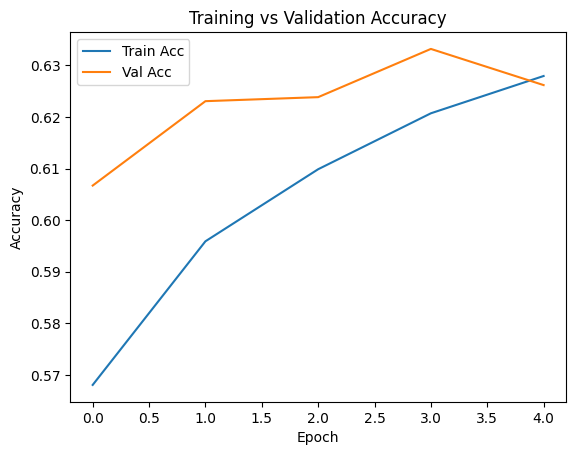

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


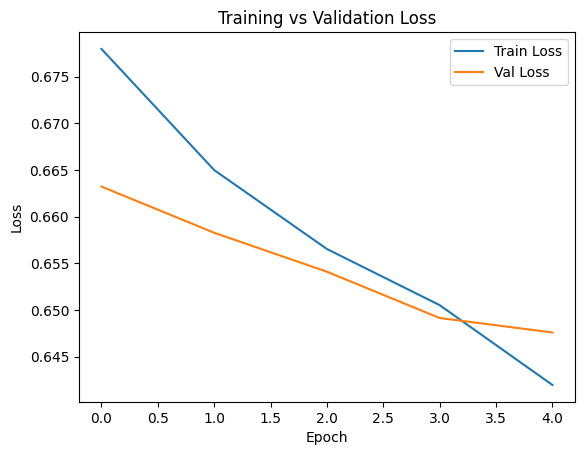

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6222 - loss: 0.6585
Test Accuracy: 0.5983


In [ ]:
from sklearn.metrics import classification_report
import time

print("\nTest Performance:")

start_test = time.time()

# Already probabilities because final layer is sigmoid
test_proba = model.predict(X_test, batch_size=16, verbose=0).ravel()
test_pred = (test_proba > 0.5).astype(int)

end_test = time.time()

test_time = end_test - start_test
test_avg_time = test_time / len(y_test)

print(classification_report(y_test, test_pred))
print(f"Test inference time: {test_time:.4f} seconds")
print(f"Average time per test sample: {test_avg_time:.6f} seconds")


Test Performance:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       553
           1       0.64      0.65      0.65       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267

Test inference time: 1.1518 seconds
Average time per test sample: 0.000909 seconds


In [ ]:
model.save('/content/drive/MyDrive/MS983/Models/LIAR_LSTM.h5')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/MS983/Models/

/content/drive/MyDrive/MS983/Models


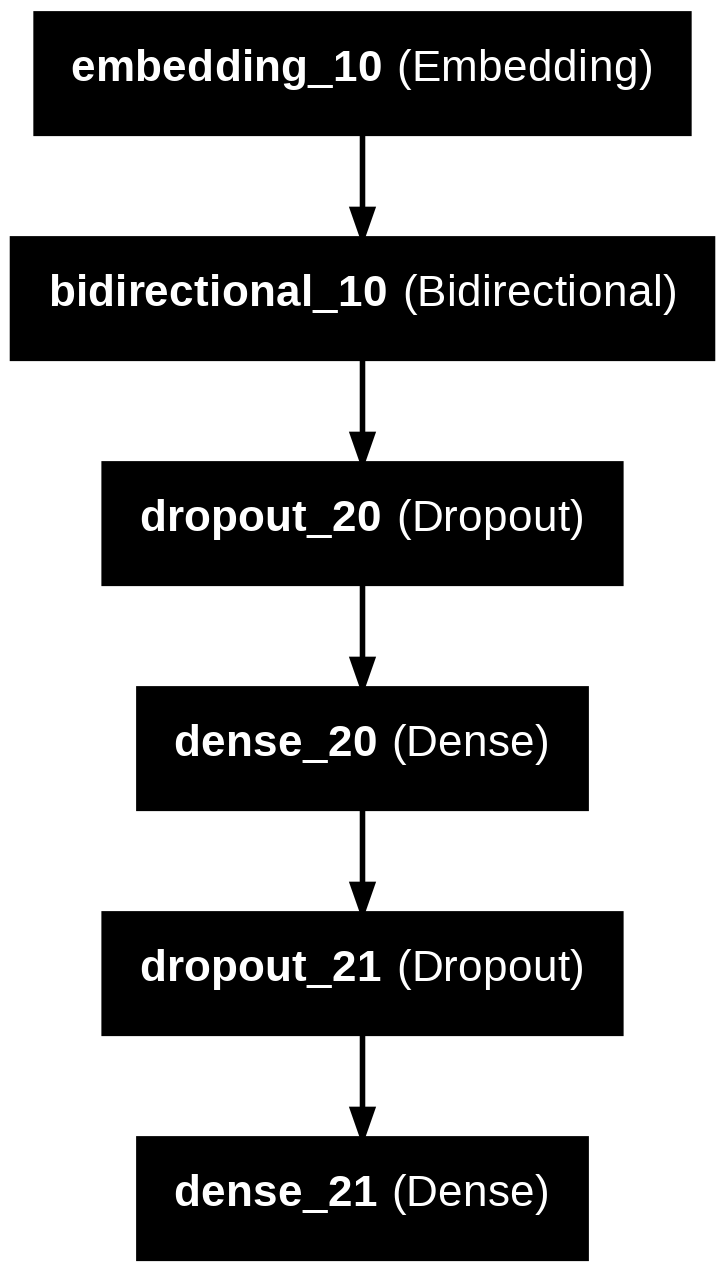

In [10]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

model = tf.keras.models.load_model('/content/drive/MyDrive/MS983/Models/LIAR_LSTM.h5')

# Plot model architecture
plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    dpi=200
)